In [1]:
import gym
import kino_envs
import numpy as np
import matplotlib.pyplot as plt


## Differential Drive

The differential drive is an 2D mobile robot. Its state is $[x, y, \theta, v, \omega]$ the 2D coordinates, the yaw angle, the speed and the angular velocity. The control is $[a_v, a_{\omega}]$, the derivative of the speed and the angular velocity. Its dynamics is

$$\begin{bmatrix}
\dot{x}\\ 
\dot{y}\\ 
\dot{\theta}\\ 
\dot{v}\\ 
\dot{\omega}
\end{bmatrix}
=
\begin{bmatrix}
v\cos(\theta)\\ 
v\sin(\theta)\\ 
\omega\\ 
a_v\\ 
a_{\omega}
\end{bmatrix}$$

The task for the robot is to reach the goal region. For reinforcement learning, its observation is 3-folder, including the current state, the acchieved goal and the desired goal. The reward is $1$ if it reaches the goal region, $-0.1$ otherwise.



observation space: Dict(achieved_goal:Box(2,), desired_goal:Box(2,), observation:Box(5,))

action space: Box(2,)


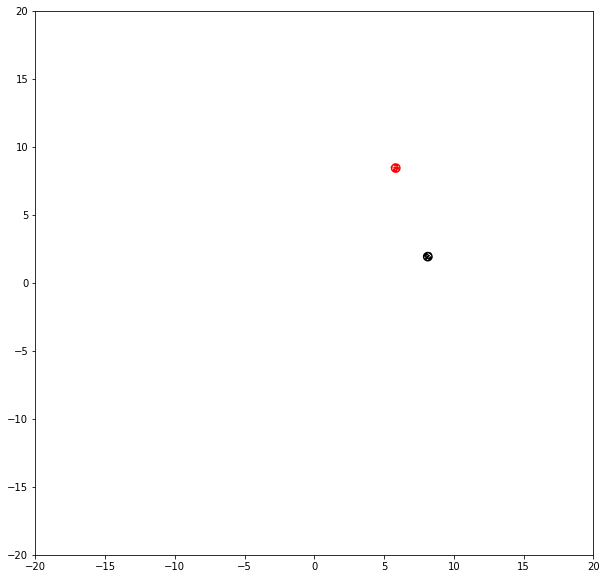

In [2]:
env = gym.make('DifferentialDrive-v0')
print(f'observation space: {env.observation_space}')
print()
print(f'action space: {env.action_space}')
env.reset()
env.render()

## Differential Drive Obstacle

Compared to above, obstacles are added in the environment. The robot needs to avoid collision while run towards the goal. The observation is 4-folder: in addition to the state, the acchieved goal and the desired goal, the agent senses the surrounding environment by a local map. The map indicates the occupancy area, the free area and the robot body via different pixel values. The reward is $-2$ if the robot is in collision, $1$ for goal reaching, $-0.1$ otherwise.



observation space: Dict(achieved_goal:Box(2,), desired_goal:Box(2,), local_map:Box(1, 51, 51), state:Box(5,))

action space: Box(2,)


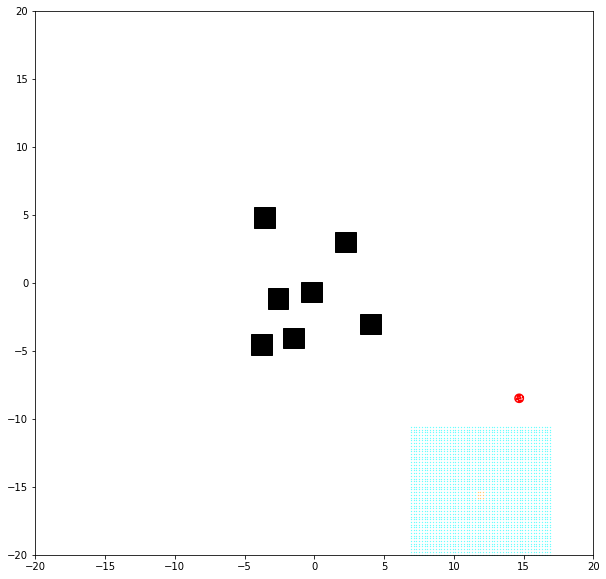

In [3]:
env = gym.make('DifferentialDriveObs-v0')
print(f'observation space: {env.observation_space}')
print()
print(f'action space: {env.action_space}')
env.reset()
obs, reward, done, info = env.step([1, 2])
env.render('local_map')

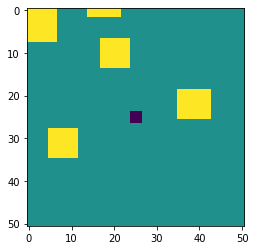

In [4]:
# show the local map
obs = env.get_obs()
img = obs['local_map']
img = img.reshape((img.shape[1:]))
plt.imshow(img)

In [5]:
from kino_envs.system.rigid import SquareObs
from kino_envs.system.differential_drive import param

In [7]:
size = 1.5
num = 7
gap = 1.5

In [8]:
def generate_one():
    obs_list = []
    for i in range(num):
        obs = SquareObs(pos=np.random.uniform([param.x_min, param.y_min],[param.x_max, param.y_max]),size=size)
        obs_list.append(obs)

    for i in range(1, num):
        obs_i = obs_list[i]
        aabb_i = np.zeros((2,2))
        aabb_i[0,:] = obs_i.pos - (obs_i.size+gap)/2
        aabb_i[1,:] = obs_i.pos + (obs_i.size+gap)/2
        for j in range(i):
            obs_j = obs_list[j]
            aabb_j = np.zeros((2,2))
            aabb_j[0,:] = obs_j.pos - (obs_j.size)/2
            aabb_j[1,:] = obs_j.pos + (obs_j.size)/2
            if aabb_intersect_aabb(aabb_i, aabb_j):
                # print('collide')
                return None
    return obs_list



In [9]:
import pickle

In [10]:
while True:
    obs_list = generate_one()

    if obs_list is not None:
        break
fig,ax = plt.subplots()
ax.axis([param.x_min, param.x_max, param.y_min, param.y_max])
param_list = [{'pos': obs.pos, 'size': obs.size, 'color': obs.color} for obs in obs_list]
pickle.dump(param_list, open('obs_4.pkl','wb'))
for obs in obs_list:
    obs.draw(ax)


NameError: name 'aabb_intersect_aabb' is not defined

In [11]:
def aabb_intersect_aabb(aabb1, aabb2):
    for i in range(2):
        if np.all(aabb1[:,i] - aabb2[0,i]<0) or np.all(aabb1[:,i] - aabb2[1,i]>0):
            return False
    return True

In [12]:
for_traj = pickle.load(open('../forward.pkl','rb'))

In [13]:
env = gym.make('DifferentialDriveObsInv-v0')
env.reset()
env.goal = for_traj[0][0].copy()
back_traj = []
for state, action, state_next, goal in for_traj[::-1]:
    state = state_next.copy()
    env.state = state_next.copy()
    env.step(action)
    state_next = env.state.copy()
    back_traj.append([state, action, state_next, env.goal.copy()])

In [14]:
images = []
env = gym.make('DifferentialDriveObsInv-v0')
env.reset()
for state, action, state_next, goal in back_traj:

    env.goal = goal.copy()
    env.state = state_next.copy()
    env.render()
    plt.savefig("tmp.png")
    images.append(plt.imread("tmp.png"))
imageio.mimsave("xxx.gif", images, duration=0.1)

<IPython.core.display.Javascript object>

NameError: name 'imageio' is not defined

In [ ]:
import imageio

In [1]:
%matplotlib notebook